<a href="https://colab.research.google.com/github/ML4SCIHackathon/ML4SCI/blob/main/NMRChallenge/Hackathon_NMR_Challenge.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Hackathon - Strongly coupled spin systems

### Problem Statement

- Nuclear Magnetic Resonance (NMR) is an experimental technique that allows for the control and measurement of nuclear spins in crystals and molecules.
- A common "recipe" for NMR is called the spin echo: the spins are aligned, let loose, and then refocused, making a sharp peak, or "echo", of the original alignment. When the spins interact with each other, the refocused echo in the magnetization $M$ can become highly distorted.
- Materials with strong electron-electron couplings have a variety of applications, from superconductivity to ferromagnetism. They also tend to enhance the nuclear spin-spin couplings, allowing NMR to act as a probe of these important systems.
- Design and train a model that predicts the strength and shape of interactions between the nuclear spins from simulated time-dependent magnetization curves, $M(t)$.


## A quick intro to NMR and spin echos

Although the NMR "spin echo" technique may sound complicated, the following animation created by Gavin W Morley (by way of https://en.wikipedia.org/wiki/Spin_echo) makes it much clearer!


![NMR Spin Echo Animation](HahnEcho_GWM.gif)


The red arrows in this animation represents the values of nuclear spins in the material.
They all begin in the same direction (up), and then an applied magnetic field rotates them into the x-y plane (indicated by the 90$^\circ$ pulse).
A constant external magnetic field in the z-direction did not affect the spins when they were pointing "up", but now that they lie in the x-y plane they begin to precess.


Because each nuclear spin sits in a slightly different magnetic environment, each one has a slightly different response to the background z-direction magnetic field, causing some to precess in a clockwise direction and others in a counterclockwise direction.


After a fixed amount of time, $t$ in the above animation, a second magnetic pulse is applied and rotates each spin 180$^\circ$ in the x-y plane.
After this, the spins continue to move as they did before, but because of the 180$^\circ$ pulse they are now effectively precessing  "backwards" compared to the original motion!
So after an additional time $t$ passes, the variations in precession time is canceled out, causing a refocusing of the spins.

This shows up as a measurable "echo" in the average spin magnetization of the material, and can be measured in experiments.
This is an important technique because the average spin magnetization is hard to measure during an applied "pulse", but there is no external pulse during the "echo", allowing for accurate measurement of the peak value and decay shape.

Here is a typical curve for the time-dependent magnetization $M(t)$ for a spin-echo in most materials:

![standard_spinecho.png](standard_spinecho.png)

Sometimes, a more complicated curve can occur, such as:

![coupled_echo.png](coupled_echo.png)

This more complicated structure has been caused by spin-spin interactions between the precessing nuclear spins. Normally, each spin precesses in a uniform way irrespective of the rest of the nuclei in the material. In this coupled case, however, the nuclear magnetization that occurs near the "echo" influences the spins' motions, modifying the shape of the observed echo.

## Electronic and nuclear spins

Most materials can be classified by their electronic properties into three categories: metal, insulator, and semiconductor.
These terms are based on a semi-classical description of the electrons in a crystal.
The electrons are treated as a collection of classical particles, with energies that depend on their momentum in a way determined by the atomic structure of the crystal.

However, there are other electronic phases of matter that are truly "quantum" and cannot be described accurately with a classical analogy.
In these scenarios, complicated structures in the electron states can give rise to large electronic spin density or strong electron-electron coupling.
Because of these strong couplings between electrons, they are often hard to probe experimentally.

Luckily, electrons can interact with the nuclar spins of a material (by way of the hyperfine-interaction).
If the electron-nuclear coupling becomes strong enough (enhanced perhaps by a "qunatum" electronic phase), then a non-neglible two-step process can couple the nuclei with each other throughout the material.
That two-step process is when a nuclear spin couples to an electron and changes its motion, and then that electron later "scatters" off another nuclear spin elsewhere in the material.

We represent this two-step scattering prcoess by way of an effective spin-spin coupling between a nuclei at position $r_j$ and $r_i$, given by:

$T(i,j) = \alpha \left( \frac{|r_j - r_i|}{\xi} \right)^{-p}$

where $\alpha$ is the coupling strength, $\xi$ the coupling length, and $p$ the power-law of the coupling.
Generally, $\alpha$, $\xi$, and $p$ will depend on the details of the nuclear-electron coupling and the quantum state of the electrons, but here we will sample them randomly to see if the spin-echo experiment can provide enough information to accurately "reverse engineer" these values from a single $M(t)$ curve.

Our simulations also include dissipation of the nuclear spins: due to couplings with the environment the spin information can be "lost".
This occurs at a time scale $T_\textrm{decay} \simeq \sqrt{\Gamma}$, with $\Gamma(d)$ given by:

$\Gamma = 10^{-d}$

In the simulated data-sets, the parameters are randomly distributed over the following ranges:
- $\alpha$: coupling strength $\in$ [0.0, 0.2]
- $\xi$: coupling length $\in$ [0, 20]
- $p$: coupling power $\in$ [2, 4]
- $d$: dissipation power $\in$ [3, 6]

Our goal is to develop a model that accurately determines the above four variables from a single $M(t)$ curve.

## Load and view the simulated data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests

mat_file = "mat_info.txt"
M_file_r = "echos_r.txt" # real part of echos
M_file_i = "echos_i.txt" # imaginary part of echos

print("Downloading files off google drive...")

# data for model creation
r = requests.get("https://docs.google.com/uc?export=download&id=1UZ8wy1Vh4iW1GyaBfWtmjnrKXeDmA2rJ",allow_redirects=True)
open(mat_file, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1G82krEg6SVB-PFOS3ei-EH4ZOcseSIEe",allow_redirects=True)
open(M_file_r, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1h8MHtV_rQg4TG-YGXqRaDzJU8oRrypCD",allow_redirects=True)
open(M_file_i, "wb").write(r.content)

# data for submission of final model
r = requests.get("https://docs.google.com/uc?export=download&id=13ejS3zuMRJUYN2ftEpxGBi8H9-u7Tpsa",allow_redirects=True)
open("submit_echos_r.txt", "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=14hexxvYKaGcCu9n_vgX5_FS0DwtqUJXN",allow_redirects=True)
open("submit_echos_i.txt", "wb").write(r.content)

print("Done with file downloads")

print("Loading into numpy arrays...")
# settings of each simulated material:
# format:  |   α  |   ξ  |   p   |   d   |
mat_info = np.loadtxt(mat_file, comments="#", delimiter='\t', unpack=False);

# M(t) curve for each simulation:
M_r = np.loadtxt(M_file_r, comments="#", delimiter='\t', unpack=False);
M_i = np.loadtxt(M_file_i, comments="#", delimiter='\t', unpack=False);
M = M_r + 1j*M_i;
print("Done with numpy loads")




Done with file downloads
Loading into numpy arrays...
Done with numpy loads


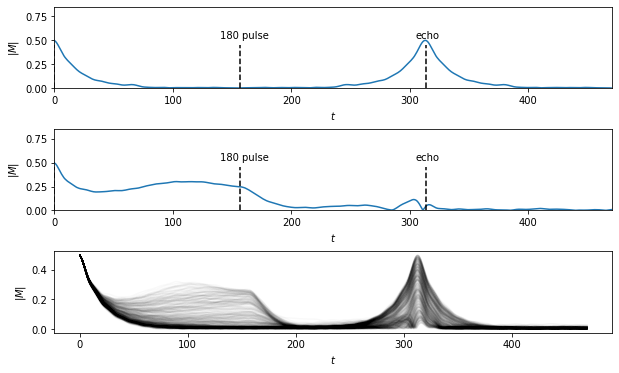

In [2]:
# view the data with three plots, two with a specific curve and one with a lot of curves
fig1, ax1 = plt.subplots(3,1, figsize=(10,6));

plot_idx1 = 0; # change this to see different curves
plot_idx2 = 10; # change this to see different curves

# string format for material parameter plotting
mat_format = "alpha: %.3f, xi: %.2f, p: %.2f, d: %.2f";

# view the selected curve, with a label of the material data
ax1[0].plot(abs(M[plot_idx1,:]));
#ax1[0].text(20,0.68, mat_format % tuple(mat_info[plot_idx1,:]) );
ax1[0].plot([0, 0],[0, .45],'--k')
ax1[0].plot([157, 157],[0, .45],'--k')
ax1[0].text(140,0.52,"180 pulse")
ax1[0].text(305,0.52,"echo")
ax1[0].plot([2*157, 2*157],[0, .45],'--k')
ax1[0].axis([0, 471, 0, 0.85])
ax1[0].set(ylabel="$|M|$", xlabel="$t$");

# view the selected curve, with a label of the material data
ax1[1].plot(abs(M[plot_idx2,:]));
#ax1[1].text(20,0.68, mat_format % tuple(mat_info[plot_idx2,:]) );
ax1[1].plot([0, 0],[0, .45],'--k')
ax1[1].plot([157, 157],[0, .45],'--k')
ax1[1].text(140,0.52,"180 pulse")
ax1[1].text(305,0.52,"echo")
ax1[1].plot([2*157, 2*157],[0, .45],'--k')
ax1[1].axis([0, 471, 0, 0.85])
ax1[1].set(ylabel="$|M|$", xlabel="$t$");

ax1[2].plot(abs(M[1:500,:]).T,color=(0,0,0,.025));
ax1[2].set(ylabel="$|M|$", xlabel="$t$");

fig1.subplots_adjust(hspace=.5)


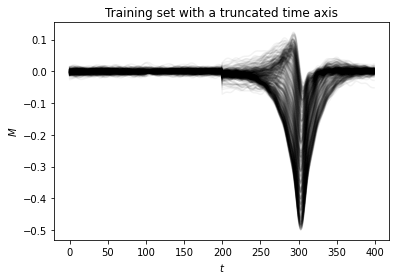

In [3]:
# partition data into a training and testing set using a random partition

N_data = np.shape(M)[0]

test_frac = 0.10 # fraction of data to save for testing data
div_idx = int(np.floor((1.0-test_frac)*N_data))

order_seed = np.random.permutation(N_data)

train_idx = order_seed[0:div_idx]
test_idx = order_seed[div_idx:N_data]


# truncate time points
time_keep = range(210,410);

M_train = M[train_idx[:,None],time_keep]
mat_train = mat_info[train_idx,:];
# concatenate the real and imaginary parts together
M_train = np.hstack( (np.real(M_train), np.imag(M_train)) )

M_test = M[test_idx[:,None],time_keep]
mat_test = mat_info[test_idx,:];
# concatenate the real and imaginary parts together
M_test = np.hstack( (np.real(M_test), np.imag(M_test)) )


plt.plot((M_train[1:500,:]).T,color=(0,0,0,.05));
plt.xlabel("$t$")
plt.ylabel("$M$")
plt.title("Training set with a truncated time axis");

## Example solution: a simple neural net (NN)
- Our input nodes are $M(t)$, the ouput nodes are the material.
- Our output nodes are the material info stored in "mat_info".
- We will use a standard NN predict the material properties from the features of $M(t)$.

The below code follows the pytorch tutorial:
https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class Net(nn.Module):

    def __init__(self, N):
        super(Net, self).__init__()
        
        # N: number of time points
        N_half = math.floor(N/2) # half scale
        
        # need to make a NN that goes from N to 4, let's try 4 layers here!
        self.l1 = nn.Linear(N,N) # a layer acting on M(t) directly
        self.l2 = nn.Linear(N,N_half) # down scale
        self.l3 = nn.Linear(N_half,24) # try to get key features
        self.l4 = nn.Linear(24,4) # 4 output channels

    def forward(self, x):
        x = F.relu(self.l1(x)) # full
        x = F.relu(self.l2(x)) # full
        x = F.relu(self.l3(x)) # full
        x = self.l4(x) # gaussian
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


N = np.shape(M_train[0])[0]
net = Net(N)
net = net.double()
print(net);
    


Net(
  (l1): Linear(in_features=400, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=200, bias=True)
  (l3): Linear(in_features=200, out_features=24, bias=True)
  (l4): Linear(in_features=24, out_features=4, bias=True)
)


In [5]:
# pick optimizer and train
import torch.optim as optim

#criterion = nn.MSELoss() # mean-square error loss
criterion = nn.SmoothL1Loss() # smooth loss, works a bit better
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # gradient descent, simple

n_epochs = 15; # number of epochs

print('Starting Training')
for epoch in range(n_epochs):  # loop over the dataset for each epoch

    running_loss = 0.0
    for idx in range(len(M_train)):
        # get the inputs; data is a list of [inputs, labels]
        inputs = torch.from_numpy(M_train[idx])
        outputs_true = torch.from_numpy(mat_train[idx])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, outputs_true)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if idx % 3500 == 3499:# and epoch % 50 == 49:    # print every few batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, idx + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Starting Training
[1,  3500] loss: 2.927
[1,  7000] loss: 2.245
[2,  3500] loss: 2.259
[2,  7000] loss: 2.242
[3,  3500] loss: 2.256
[3,  7000] loss: 2.240
[4,  3500] loss: 2.253
[4,  7000] loss: 2.238
[5,  3500] loss: 2.251
[5,  7000] loss: 2.236
[6,  3500] loss: 2.248
[6,  7000] loss: 2.233
[7,  3500] loss: 2.245
[7,  7000] loss: 2.229
[8,  3500] loss: 2.237
[8,  7000] loss: 2.215
[9,  3500] loss: 2.208
[9,  7000] loss: 2.182
[10,  3500] loss: 2.190
[10,  7000] loss: 2.171
[11,  3500] loss: 2.184
[11,  7000] loss: 2.165
[12,  3500] loss: 2.177
[12,  7000] loss: 2.158
[13,  3500] loss: 2.170
[13,  7000] loss: 2.150
[14,  3500] loss: 2.163
[14,  7000] loss: 2.143
[15,  3500] loss: 2.156
[15,  7000] loss: 2.136
Finished Training


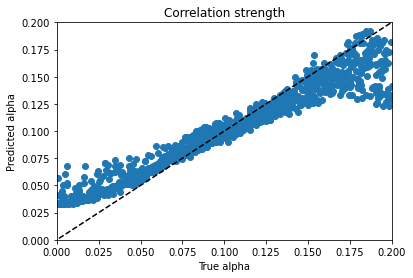

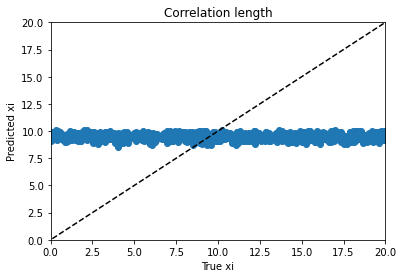

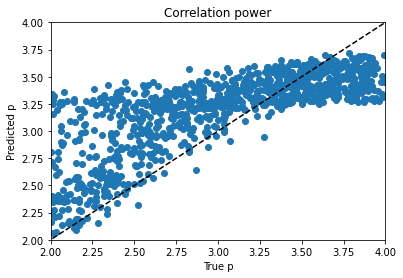

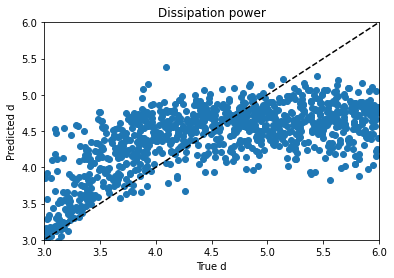

In [6]:
# check results on test set

nn_info = np.zeros( (len(M_test),4) )
for idx in range(len(M_test)):
    inputs = torch.from_numpy(M_test[idx])
    outputs = net(inputs)
    nn_info[idx,:] = outputs.detach().numpy()
    
plt.scatter(mat_test[:,0],nn_info[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],nn_info[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],nn_info[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],nn_info[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");



## Heatmap of important features in the time domain

It can be helpful to try to gauge the relative "importance" of the inputs to a NN.


Does the real part of the data (first half of t-axis) seem important?

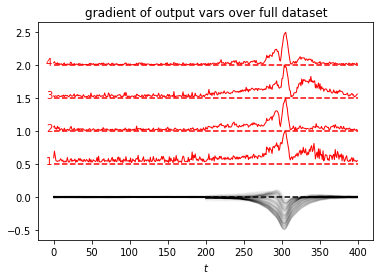

In [7]:
# heatmap of feature importance in the time domain

plt.plot(M_test[1:300,:].T,color=(0,0,0,.02),linewidth=1);
plt.plot([0,N],[0,0],"--k")

# loop over each output variable
for var_idx in range(4):
    grad_h = np.zeros((np.shape(M_test)[1]))
    s_h = 0.5 + var_idx*0.5;

    # sum over each testing curve, get gradient
    for plot_idx in range(len(M_test)):
        input = torch.from_numpy(M_test[plot_idx])
        input.requires_grad = True
        output = net(input)[var_idx]
        output.backward()
        grad_h = grad_h + abs(input.grad.data.detach().numpy());

    grad_h = 0.5*grad_h/max(grad_h)

    plt.plot(grad_h+s_h,color=(1,0,0),linewidth=1);
    plt.plot([0,N],[s_h,s_h],"--r")
    plt.text(-10,s_h,var_idx+1,color="r")

plt.title("gradient of output vars over full dataset");
plt.xlabel("$t$");


## Submission format

When we downloaded the data for the model development, we also downloaded 500 spin echos into "submit_echos_r.txt" and "submit_echos_i.txt".
These share the same format as the "echos.txt" used for the model training above.

Use your model to predict the four spin-interaction variables from the 500 echos, and submit your results in a tab delimited .txt file of dimensions 500 x 4 matching the "mat_info.txt" format.

That is, the columns should be:

| $\alpha$ | $\xi$ | $p$ | $d$ |
      
and there should be 500 rows.

Name this file "submitted_mat_info.txt"

The quality of the model will be judged by the minimization of the error function:


$\textrm{Err} = \sum_{v=1}^{4} \sum_{i=i}^{500} \left( \frac{v^i_\textrm{model} - v^i_\textrm{true}}{w(v)} \right)^2 $

where $v^i$ is one of the four spin-interaction variables for echo number $i$, and $w_v$ normalizes the variation in each variable, according to:

$w(\alpha) = 0.2$

$w(\xi) = 20$

$w(p) = 2$

$w(d) = 3.$

Your submission should include your notebook as well as the predicted value file "submitted_mat_info.txt"
